In [1]:
from matplotlib import pyplot as plt
import numpy as np
import skimage, skimage.morphology, skimage.feature
%matplotlib inline

Computes a homogeneous line vector from the $\rho$, $\theta$ parameters returned by SKImage's Hough transform

In [2]:
def homline(rho, theta):
    return [np.cos(theta), np.sin(theta), -rho]

Returns intersection of two homogeneous lines

**TODO:** Points at the infinity are not handled properly

In [3]:
def homintersect(l1, l2):
    p = np.cross(l1, l2)
    p = p/p[2]
    return p

Produces an image of the same shape given as second parameter, representing the geometrical locus of the predicate in the first parameter: the image is 1 if the predicate holds, 0 otherwise.

In [4]:
def locus_imshape(pred, shape):
    return np.array([[1.0 if pred(x, y) else 0.0 for x in range(0, shape[1])] for y in range(0, shape[0])])

In [5]:
pic = plt.imread("pics2/3.JPG")

`bwpic` is the B/W version of the analysed picture

**TODO:** Thresholding is not a good method to isolate the table surface. Some kind of colour segmentation would be better, especially if it took into account local colour continuity.

In [6]:
bwpic = np.linalg.norm(pic, axis=2)
bwpic = skimage.filters.median(bwpic.astype("uint16"), skimage.morphology.disk(8))
bwpic = bwpic/np.max(bwpic)
maskpic = skimage.morphology.binary_dilation(bwpic > 0.8)
maskpic = skimage.morphology.binary_dilation(maskpic)

A histogram is temporarily used to find a good threshold for the table surface

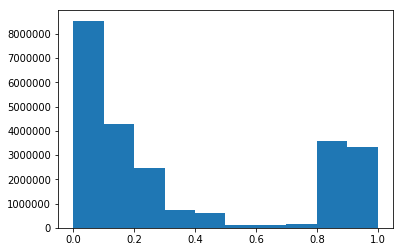

In [7]:
plt.figure("hist")
_ = plt.hist(bwpic.flatten())

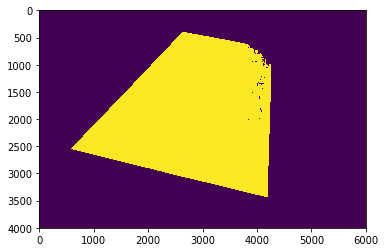

In [8]:
plt.figure("bwmed")
plt.imshow(maskpic)

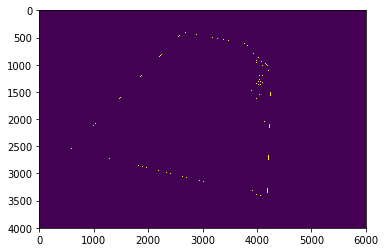

In [9]:
cannypic = skimage.feature.canny(maskpic)
plt.figure('canny')
plt.imshow(cannypic)

In [10]:
hres = skimage.transform.hough_line(cannypic)
threshold = 0.1*np.max(hres[0])
_, angles, dists = skimage.transform.hough_line_peaks(*hres, num_peaks=4, threshold=threshold, min_distance=100)

lines = [homline(rho, theta) for rho, theta in zip(dists, angles)]
assert(len(lines) == 4), f"Should be 4 lines, not {len(lines)}!"

Vanishing points are found by assuming that the lines with the closest angles are images of parallel lines.

**TODO:** Verify that the assumption is formally valid.

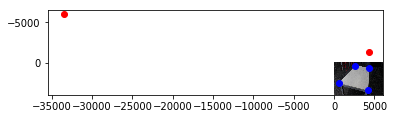

In [11]:
# The angle space should be continuous between -pi/2 and pi/2, so we throw the antipodal angles into the mix
# The indices will be restored by modding by 4
angles_xt = list(enumerate(np.concatenate((angles, angles+np.pi))))
angle_cpls = [((i, x), (j, y)) for i, x in angles_xt for j, y in angles_xt if i<j]
# The angles are the second elements of each (i, x) tuple in the couple
mindstcpl = min(angle_cpls, key=lambda ix_jy: abs(ix_jy[0][1]-ix_jy[1][1]))
par_idcs1 = [mindstcpl[0][0]%4, mindstcpl[1][0]%4]
par_idcs2 = [i for i in range(4) if i not in par_idcs1]

# Not very elegant, I know
vp1 = homintersect(lines[par_idcs1[0]], lines[par_idcs1[1]])
vp2 = homintersect(lines[par_idcs2[0]], lines[par_idcs2[1]])
intersections = np.array([homintersect(lines[i], lines[j]) for i in par_idcs1 for j in par_idcs2])

vps = np.array([vp1, vp2])

plt.figure("points")
plt.imshow(pic)
plt.plot(intersections[:,0], intersections[:,1], 'bo')
plt.plot(vps[:, 0], vps[:, 1], 'ro')